In [1]:
import numpy as np
import pandas as pd
import time
from datetime import datetime
from tqdm import tqdm
#from numba import njit
#import dask.dataframe as dd
from concurrent.futures import ThreadPoolExecutor
from cloudvolume import CloudVolume
from caveclient import CAVEclient
import networkx as nx
from scipy.spatial import ConvexHull, distance
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
import re

#Skeleton
import pcg_skel

# CloudVolume and Cave setup
sv = CloudVolume('graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3', use_https=True, lru_bytes=int(1e8))
client = CAVEclient('zheng_ca3')

In [2]:
def get_percentile(df_boutonsize, bottom=False, percentile=95):
    
    # Calculate the threshold for the top 10% bouton sizes
    threshold = np.percentile(df_boutonsize["bouton_vol_um3"], percentile)  # Get the 90th percentile value
    
    if bottom:
        # Filter the DataFrame to keep only rows where 'bouton_vol_um3' is in the bottom 10%
        df_boutonsize = df_boutonsize[df_boutonsize["bouton_vol_um3"] <= threshold].copy()

        
    else:
        # Filter the DataFrame to keep only rows where 'bouton_vol_um3' is in the top 10%
        df_boutonsize = df_boutonsize[df_boutonsize["bouton_vol_um3"] >= threshold].copy()

    print(f"Number of Mossy Fibers: {len(df_boutonsize)}")
    return df_boutonsize


def find_synapses(df):
    # Check API rate limit before making the synapse query
    api_call_start_time = time.time()  # FIXED: Added parentheses
    api_call_counter = 0
    manage_api_rate_limit()
    
    current_date = datetime.now().strftime('%Y%m%d')

    # Extract segment IDs and ensure they are integers
    if f"updated_segids_{current_date}" not in df.columns:
        print(f"Error: Column 'updated_segids_{current_date}' not found in DataFrame.")
        return pd.DataFrame(), 0, 0

    # Drop NaNs, convert to integers, and ensure correct type
    segids = df[f"updated_segids_{current_date}"].dropna().astype(int).tolist()  

    if not segids:
        print("No segment IDs found to query.")
        return pd.DataFrame(), 0, 0  # Return empty dataframe if no segids

    # Chunk the list into groups of 200 to avoid API overload
    chunks = [list(map(int, segids[i:i + 200])) for i in range(0, len(segids), 200)]

    results_list = []  # Store all retrieved DataFrames
    counter_error = 0

    with tqdm(total=len(chunks), desc="Processing Mossy Fiber Synapses") as pbar:
        for idx, presyn_segids_chunk in enumerate(chunks):
            try:
                # Query synapse data for the current chunk
                df_synapse = client.materialize.synapse_query(
                    pre_ids=presyn_segids_chunk,
                    post_ids=None,
                    synapse_table="synapses_ca3_v1",
                    desired_resolution=[18, 18, 45]
                )
                api_call_counter += 1  # Increment API call counter


                if not df_synapse.empty:
                    results_list.append(df_synapse)

                pbar.update(1)  # Update progress bar on success

            except Exception as e:
                print(f"Error querying synapse for chunk {idx + 1}/{len(chunks)}: {e}")
                print("Retrying after 20 seconds...")
                counter_error += 1
                print(f"Number of Errors: {counter_error}")
                time.sleep(20)
                manage_api_rate_limit()  # Ensure rate limit before retrying

                try:
                    df_synapse = client.materialize.synapse_query(
                        pre_ids=presyn_segids_chunk, 
                        post_ids=None,
                        synapse_table="synapses_ca3_v1",
                        desired_resolution=[18, 18, 45]
                    )
                    api_call_counter += 1  # Increment API call counter

                    if not df_synapse.empty:
                        results_list.append(df_synapse)

                except Exception as e2:
                    print(f"Second attempt failed for chunk {idx + 1}/{len(chunks)}: {e2}")
                    print("Skipping this chunk.")

                pbar.update(1)  # Update progress even if retry fails

    # Concatenate results into a single DataFrame
    df_synapses = pd.concat(results_list, ignore_index=True) if results_list else pd.DataFrame()

    return df_synapses, counter_error, api_call_counter


def manage_api_rate_limit():
    
    """Ensures that the number of API calls does not exceed the limit."""
    global api_call_counter, api_call_start_time

    elapsed_time = time.time() - api_call_start_time
    if elapsed_time < 65 and api_call_counter >= 295:
        time_to_sleep = 70 - elapsed_time
        print(f"Rate limit reached. Sleeping for {time_to_sleep:.2f} seconds...")
        time.sleep(time_to_sleep)
        api_call_start_time = time.time()  # Reset the timer
        api_call_counter = 0
    elif elapsed_time >= 60:
        # Reset counter and timer after a minute
        api_call_start_time = time.time()
        api_call_counter = 0
        

def update_segids_df(df, super_voxel_col):
    # Ensure column exists
    if super_voxel_col not in df.columns:
        raise ValueError(f"Column '{super_voxel_col}' not found in DataFrame")

    # Convert to string first to avoid scientific notation issues, then to int
    #df[super_voxel_col] = df[super_voxel_col].astype(str).str.replace(',', '')  # Remove commas if any
    #df[super_voxel_col] = df[super_voxel_col].apply(lambda x: int(float(x)))  # Convert safely to int

    # Update segids
    updated_segid_list = client.chunkedgraph.get_roots(df[super_voxel_col].astype(np.uint64))

    # Add the updated segids to the DataFrame with the date in the column name
    current_date = datetime.now().strftime('%Y%m%d')
    df[f"updated_segids_{current_date}"] = updated_segid_list

    return df, len(updated_segid_list), 0  # Return the updated DataFrame


def filter_known_pyr_cells(df_boutonsize, df_pyr):

    current_date = datetime.now().strftime('%Y%m%d')
    
    # Get the column name dynamically
    pyr_column = f"updated_segids_{current_date}"
    
    # Extract unique values from df_pyr
    known_segids = set(df_pyr[pyr_column].unique())
    
    # Filter df_boutonsize to keep only rows where post_pt_root_id is in known_segids
    df_boutonsize = df_boutonsize[~df_boutonsize["post_pt_root_id"].astype(str).isin(map(str, known_segids))]
    
    return df_boutonsize


def add_bouton_data(df_mf_syn_nopyr, df_boutonsize):

    bouton_data = df_boutonsize.set_index("pre_mf_id")[["syn_cluster_center", "numsyn", "bouton_vol_um3"]]

    df_mf_syn_nopyr = df_mf_syn_nopyr.merge(
        df_boutonsize[["pre_mf_id", "syn_cluster_center", "numsyn", "bouton_vol_um3"]],
        left_on="pre_pt_root_id",
        right_on="pre_mf_id",
        how="left"
    ).drop(columns=["pre_mf_id"])  # Drop redundant column

    return df_mf_syn_nopyr

import numpy as np
import pandas as pd
import ast
import re

def calculate_euc_dis(df):
    # Function to safely convert a string to a list of floats
    def safe_eval_list(coord_string):
        if isinstance(coord_string, bytes):
            coord_string = coord_string.decode("utf-8")  # Convert bytes to string if needed
        
        if isinstance(coord_string, str):
            # Ensure numbers are separated by commas where necessary
            coord_string = re.sub(r'(?<=\d)\s+(?=\d)', ', ', coord_string)

            try:
                # Use ast.literal_eval for safety
                parsed = ast.literal_eval(coord_string)
                
                # Ensure it's a valid numeric list
                if isinstance(parsed, (list, tuple)) and all(isinstance(i, (int, float)) for i in parsed):
                    return np.array(parsed, dtype=float)  # Convert to NumPy array
                else:
                    raise ValueError("Parsed result is not a valid list of numbers")

            except (ValueError, SyntaxError) as e:
                print(f"Error evaluating: {coord_string} - {e}")
                return np.nan  # Handle errors by returning NaN
        
        # If it's already an array, return as is
        if isinstance(coord_string, (list, np.ndarray)):
            return np.array(coord_string, dtype=float)
        
        return np.nan  # Handle unexpected types

    # Apply the function to clean and convert coordinates
    df["ctr_pt_position"] = df["ctr_pt_position"].apply(safe_eval_list)
    df["syn_cluster_center"] = df["syn_cluster_center"].apply(safe_eval_list)

    # Function to scale XYZ coordinates
    def scale_coordinates(coord):
        if isinstance(coord, bytes):
            coord = coord.decode("utf-8")  # Convert bytes to string if needed

        if isinstance(coord, str):
            coord = re.sub(r'(?<=\d)\s+(?=\d)', ', ', coord)
            try:
                parsed = ast.literal_eval(coord)
                if isinstance(parsed, (list, tuple)) and len(parsed) == 3:
                    coords = np.array(parsed, dtype=float)
                else:
                    raise ValueError("Invalid coordinate format")
            except Exception as e:
                print(f"Error processing: {coord} - {e}")
                return np.nan
        elif isinstance(coord, (list, np.ndarray)) and len(coord) == 3:
            coords = np.array(coord, dtype=float)
        else:
            return np.nan  # If invalid type, return NaN

        # **Apply scaling**
        coords[0] *= 18 # Scale X
        coords[1] *= 18 # Scale Y
        coords[2] *= 45  # Scale Z
        
        return coords  

    # Apply scaling function to both coordinate columns
    df["ctr_pt_position"] = df["ctr_pt_position"].apply(scale_coordinates)
    df["syn_cluster_center"] = df["syn_cluster_center"].apply(scale_coordinates)

    # Debugging Step: Print out the first few rows after scaling
    print("After Scaling:")
    print(df[["ctr_pt_position", "syn_cluster_center"]].head())

    # Compute Euclidean distance
    df["bouton_distance"] = df.apply(
        lambda row: np.linalg.norm(row["ctr_pt_position"] - row["syn_cluster_center"]) 
        if isinstance(row["ctr_pt_position"], np.ndarray) and isinstance(row["syn_cluster_center"], np.ndarray) 
        else np.nan,
        axis=1
    )
    
    # Last scaling
    df['bouton_distance'] = df['bouton_distance'] / 1000
    
    return df


def assign_repeat_counts(df, column="pre_pt_root_id"):
    """
    Assigns the count of occurrences of each unique value in the specified column.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column (str): The column name to process (default is "pre_pt_root_id").
    
    Returns:
        pd.DataFrame: A DataFrame with a new column 'repeat_count' indicating 
                      the count of occurrences of each unique value.
    """
    df = df.copy()  # Avoid modifying the original DataFrame
    df["pre_syn_counts"] = df.groupby(column)[column].transform("count")
    return df


def assign_repeat_counts_2(df, column="post_pt_root_id"):
    """
    Assigns the count of occurrences of each unique value in the specified column.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column (str): The column name to process (default is "pre_pt_root_id").
    
    Returns:
        pd.DataFrame: A DataFrame with a new column 'repeat_count' indicating 
                      the count of occurrences of each unique value.
    """
    df = df.copy()  # Avoid modifying the original DataFrame
    df["post_syn_counts"] = df.groupby(column)[column].transform("count")
    return df


def filter_non_inhibtory_cells(df_boutonsize, df_inhib):
    current_date = datetime.now().strftime('%Y%m%d')
    
    # Get the column name dynamically
    inhib_column = f"updated_segids_{current_date}"
    
    # ✅ Ensure df_inhib is a DataFrame before accessing columns
    if not isinstance(df_inhib, pd.DataFrame):
        raise TypeError(f"Expected df_inhib to be a DataFrame, but got {type(df_inhib)}")

    # ✅ Ensure the column exists in df_inhib before proceeding
    if inhib_column not in df_inhib.columns:
        raise ValueError(f"Column '{inhib_column}' not found in df_inhib DataFrame")

    # Extract unique values from df_inhib (converted to strings for safe comparison)
    known_segids = set(df_inhib[inhib_column].dropna().astype(str).unique())

    # ✅ Convert `post_pt_root_id` to string before filtering
    df_boutonsize = df_boutonsize[df_boutonsize["post_pt_root_id"].astype(str).isin(known_segids)]
    
    return df_boutonsize

def convert_sci_to_int(value):
    """Convert a value in scientific notation to an exact integer."""
    try:
        if isinstance(value, float) or 'e' in str(value).lower():  # Detect scientific notation
            return int(float(value))  # Convert to float first, then exact int
        return int(value)  # Convert normally if it's already a number
    except ValueError:
        return np.nan  # Handle invalid cases


### Load and Process Pyr Data

In [3]:
df_boutonsize = pd.read_csv('bouton_info_for_GT_mf_pyr.csv')
df_boutonsize, _ , _ = update_segids_df(df_boutonsize, super_voxel_col='pre_mf_id')
df_pyr = pd.read_csv('all_pyramidal_cells - all_pyr_v2_remove_dupes_20250404.csv')
df_pyr, _, _ = update_segids_df(df_pyr, super_voxel_col='supervoxel')

In [4]:
api_call_start_time = time.time()
api_call_counter = 0
df_mf_synapses, _ , _ = find_synapses(df_boutonsize)
df_mf_syn_nopyr = filter_known_pyr_cells(df_mf_synapses, df_pyr)
df_mf_syn = add_bouton_data(df_mf_synapses, df_boutonsize)
df_mf_syn_dist = calculate_euc_dis(df_mf_syn)
df_mf_syn_dist.head(1)

Processing Mossy Fiber Synapses: 100%|████| 112/112 [03:28<00:00,  1.86s/it]


Error evaluating: [56704.         69767.83333333, 1546.08333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [56704.         69767.83333333, 1546.08333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [56869.  70422.4, 2039.6] - invalid syntax (<unknown>, line 1)
Error evaluating: [56869.  70422.4, 2039.6] - invalid syntax (<unknown>, line 1)
Error evaluating: [56869.  70422.4, 2039.6] - invalid syntax (<unknown>, line 1)
Error evaluating: [46774.         50352.41176471, 712.88235294] - invalid syntax (<unknown>, line 1)
Error evaluating: [46774.         50352.41176471, 712.88235294] - invalid syntax (<unknown>, line 1)
Error evaluating: [46774.         50352.41176471, 712.88235294] - invalid syntax (<unknown>, line 1)
Error evaluating: [46774.         50352.41176471, 712.88235294] - invalid syntax (<unknown>, line 1)
Error evaluating: [46774.         50352.41176471, 712.88235294] - invalid syntax (<unknown>, line 1)
Error evaluating: [46774.         50352.41176471

Error evaluating: [34267.77272727, 72602.          1817.41010101] - invalid syntax (<unknown>, line 1)
Error evaluating: [34267.77272727, 72602.          1817.41010101] - invalid syntax (<unknown>, line 1)
Error evaluating: [34267.77272727, 72602.          1817.41010101] - invalid syntax (<unknown>, line 1)
Error evaluating: [34267.77272727, 72602.          1817.41010101] - invalid syntax (<unknown>, line 1)
Error evaluating: [34267.77272727, 72602.          1817.41010101] - invalid syntax (<unknown>, line 1)
Error evaluating: [34267.77272727, 72602.          1817.41010101] - invalid syntax (<unknown>, line 1)
Error evaluating: [34267.77272727, 72602.          1817.41010101] - invalid syntax (<unknown>, line 1)
Error evaluating: [34267.77272727, 72602.          1817.41010101] - invalid syntax (<unknown>, line 1)
Error evaluating: [34267.77272727, 72602.          1817.41010101] - invalid syntax (<unknown>, line 1)
Error evaluating: [34267.77272727, 72602.          1817.41010101] - inval

Error evaluating: [54193.  60219.5, 1296. ] - invalid syntax (<unknown>, line 1)
Error evaluating: [54193.  60219.5, 1296. ] - invalid syntax (<unknown>, line 1)
Error evaluating: [54193.  60219.5, 1296. ] - invalid syntax (<unknown>, line 1)
Error evaluating: [54193.  60219.5, 1296. ] - invalid syntax (<unknown>, line 1)
Error evaluating: [54193.  60219.5, 1296. ] - invalid syntax (<unknown>, line 1)
Error evaluating: [54193.  60219.5, 1296. ] - invalid syntax (<unknown>, line 1)
Error evaluating: [54193.  60219.5, 1296. ] - invalid syntax (<unknown>, line 1)
Error evaluating: [45314.         50136.33333333, 343.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [45314.         50136.33333333, 343.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [45314.         50136.33333333, 343.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [45314.         50136.33333333, 343.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [45314.    

Error evaluating: [46713.76923077, 56962.          1452.23076923] - invalid syntax (<unknown>, line 1)
Error evaluating: [49977.66666667, 55344.           854.90909091] - invalid syntax (<unknown>, line 1)
Error evaluating: [34357.         67762.20833333, 309.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [36136.33333333, 64952.          1696.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [36136.33333333, 64952.          1696.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [36136.33333333, 64952.          1696.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [36136.33333333, 64952.          1696.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [36136.33333333, 64952.          1696.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [36136.33333333, 64952.          1696.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [36136.33333333, 64952.          1696.        ] - invalid

Error evaluating: [33802.         72877.23076923, 993.80769231] - invalid syntax (<unknown>, line 1)
Error evaluating: [34084.9, 72242.   1254.9] - invalid syntax (<unknown>, line 1)
Error evaluating: [33802.         72877.23076923, 993.80769231] - invalid syntax (<unknown>, line 1)
Error evaluating: [33802.         72877.23076923, 993.80769231] - invalid syntax (<unknown>, line 1)
Error evaluating: [33802.         72877.23076923, 993.80769231] - invalid syntax (<unknown>, line 1)
Error evaluating: [33964.         72796.28571429, 955.71428571] - invalid syntax (<unknown>, line 1)
Error evaluating: [33802.         72877.23076923, 993.80769231] - invalid syntax (<unknown>, line 1)
Error evaluating: [33802.         72877.23076923, 993.80769231] - invalid syntax (<unknown>, line 1)
Error evaluating: [33964.         72796.28571429, 955.71428571] - invalid syntax (<unknown>, line 1)
Error evaluating: [33802.         72877.23076923, 993.80769231] - invalid syntax (<unknown>, line 1)
Error eva

Error evaluating: [36701.         66356.44444444, 1300.22222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [36701.         66356.44444444, 1300.22222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [36701.         66356.44444444, 1300.22222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [36701.         66356.44444444, 1300.22222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [55633.         64137.96969697, 1764.21212121] - invalid syntax (<unknown>, line 1)
Error evaluating: [55633.         64137.96969697, 1764.21212121] - invalid syntax (<unknown>, line 1)
Error evaluating: [55633.         64137.96969697, 1764.21212121] - invalid syntax (<unknown>, line 1)
Error evaluating: [55633.         64137.96969697, 1764.21212121] - invalid syntax (<unknown>, line 1)
Error evaluating: [55633.         64137.96969697, 1764.21212121] - invalid syntax (<unknown>, line 1)
Error evaluating: [55633.         64137.96969697, 1764.21212121] - invalid syntax 

Error evaluating: [43222.         57129.5, 1242.05555556] - invalid syntax (<unknown>, line 1)
Error evaluating: [43222.         57129.5, 1242.05555556] - invalid syntax (<unknown>, line 1)
Error evaluating: [34165.52631579, 69598.           465.57894737] - invalid syntax (<unknown>, line 1)
Error evaluating: [34165.52631579, 69598.           465.57894737] - invalid syntax (<unknown>, line 1)
Error evaluating: [34165.52631579, 69598.           465.57894737] - invalid syntax (<unknown>, line 1)
Error evaluating: [43222.         57129.5, 1242.05555556] - invalid syntax (<unknown>, line 1)
Error evaluating: [34165.52631579, 69598.           465.57894737] - invalid syntax (<unknown>, line 1)
Error evaluating: [43222.         57129.5, 1242.05555556] - invalid syntax (<unknown>, line 1)
Error evaluating: [43222.         57129.5, 1242.05555556] - invalid syntax (<unknown>, line 1)
Error evaluating: [43222.         57129.5, 1242.05555556] - invalid syntax (<unknown>, line 1)
Error evaluating: 

Error evaluating: [46832.11111111, 50910.           578.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46832.11111111, 50910.           578.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46832.11111111, 50910.           578.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46832.11111111, 50910.           578.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46832.11111111, 50910.           578.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46832.11111111, 50910.           578.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46832.11111111, 50910.           578.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46832.11111111, 50910.           578.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46832.11111111, 50910.           578.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46832.11111111, 50910.           578.66666667] - inval

Error evaluating: [48546.81196581, 54919.          1008.38205128] - invalid syntax (<unknown>, line 1)
Error evaluating: [48546.81196581, 54919.          1008.38205128] - invalid syntax (<unknown>, line 1)
Error evaluating: [48546.81196581, 54919.          1008.38205128] - invalid syntax (<unknown>, line 1)
Error evaluating: [35818.82352941, 68958.           758.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [35818.82352941, 68958.           758.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [35818.82352941, 68958.           758.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [35818.82352941, 68958.           758.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [35818.82352941, 68958.           758.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [35818.82352941, 68958.           758.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [35818.82352941, 68958.           758.        ] - inval

Error evaluating: [39873.46153846, 64704.          1616.61538462] - invalid syntax (<unknown>, line 1)
Error evaluating: [39873.46153846, 64704.          1616.61538462] - invalid syntax (<unknown>, line 1)
Error evaluating: [39873.46153846, 64704.          1616.61538462] - invalid syntax (<unknown>, line 1)
Error evaluating: [42065.         59094.6, 917.10222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [39873.46153846, 64704.          1616.61538462] - invalid syntax (<unknown>, line 1)
Error evaluating: [42065.         59094.6, 917.10222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [42065.         59094.6, 917.10222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [39873.46153846, 64704.          1616.61538462] - invalid syntax (<unknown>, line 1)
Error evaluating: [44569.2, 57170.   1542.2] - invalid syntax (<unknown>, line 1)
Error evaluating: [44569.2, 57170.   1542.2] - invalid syntax (<unknown>, line 1)
Error evaluating: [44569.2, 57170.   15

Error evaluating: [48096.  51407.5, 310.5] - invalid syntax (<unknown>, line 1)
Error evaluating: [48096.  51407.5, 310.5] - invalid syntax (<unknown>, line 1)
Error evaluating: [48096.  51407.5, 310.5] - invalid syntax (<unknown>, line 1)
Error evaluating: [48096.  51407.5, 310.5] - invalid syntax (<unknown>, line 1)
Error evaluating: [48096.  51407.5, 310.5] - invalid syntax (<unknown>, line 1)
Error evaluating: [48096.  51407.5, 310.5] - invalid syntax (<unknown>, line 1)
Error evaluating: [48096.  51407.5, 310.5] - invalid syntax (<unknown>, line 1)
Error evaluating: [48096.  51407.5, 310.5] - invalid syntax (<unknown>, line 1)
Error evaluating: [48096.  51407.5, 310.5] - invalid syntax (<unknown>, line 1)
Error evaluating: [48096.  51407.5, 310.5] - invalid syntax (<unknown>, line 1)
Error evaluating: [48096.  51407.5, 310.5] - invalid syntax (<unknown>, line 1)
Error evaluating: [48096.  51407.5, 310.5] - invalid syntax (<unknown>, line 1)
Error evaluating: [48096.  51407.5, 310.

Error evaluating: [35523.         64864.43333333, 351.01066667] - invalid syntax (<unknown>, line 1)
Error evaluating: [42861.         57471.04761905, 1108.14285714] - invalid syntax (<unknown>, line 1)
Error evaluating: [37569.0625, 63497.       421.25  ] - invalid syntax (<unknown>, line 1)
Error evaluating: [35523.         64864.43333333, 351.01066667] - invalid syntax (<unknown>, line 1)
Error evaluating: [35523.         64864.43333333, 351.01066667] - invalid syntax (<unknown>, line 1)
Error evaluating: [35523.         64864.43333333, 351.01066667] - invalid syntax (<unknown>, line 1)
Error evaluating: [35523.         64864.43333333, 351.01066667] - invalid syntax (<unknown>, line 1)
Error evaluating: [34265.         70252.41666667, 529.83333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [34265.         70252.41666667, 529.83333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [47252.     52766.5625, 426.8125] - invalid syntax (<unknown>, line 1)
Error evalu

Error evaluating: [36856.0625, 65739.      1434.5625] - invalid syntax (<unknown>, line 1)
Error evaluating: [36856.0625, 65739.      1434.5625] - invalid syntax (<unknown>, line 1)
Error evaluating: [36856.0625, 65739.      1434.5625] - invalid syntax (<unknown>, line 1)
Error evaluating: [46447.5, 54989.     938.75] - invalid syntax (<unknown>, line 1)
Error evaluating: [46447.5, 54989.     938.75] - invalid syntax (<unknown>, line 1)
Error evaluating: [46447.5, 54989.     938.75] - invalid syntax (<unknown>, line 1)
Error evaluating: [46447.5, 54989.     938.75] - invalid syntax (<unknown>, line 1)
Error evaluating: [46447.5, 54989.     938.75] - invalid syntax (<unknown>, line 1)
Error evaluating: [46447.5, 54989.     938.75] - invalid syntax (<unknown>, line 1)
Error evaluating: [46447.5, 54989.     938.75] - invalid syntax (<unknown>, line 1)
Error evaluating: [46447.5, 54989.     938.75] - invalid syntax (<unknown>, line 1)
Error evaluating: [36856.0625, 65739.      1434.5625] -

Error evaluating: [37812.         57463.15384615, 801.69230769] - invalid syntax (<unknown>, line 1)
Error evaluating: [37812.         57463.15384615, 801.69230769] - invalid syntax (<unknown>, line 1)
Error evaluating: [37812.         57463.15384615, 801.69230769] - invalid syntax (<unknown>, line 1)
Error evaluating: [37812.         57463.15384615, 801.69230769] - invalid syntax (<unknown>, line 1)
Error evaluating: [37812.         57463.15384615, 801.69230769] - invalid syntax (<unknown>, line 1)
Error evaluating: [37812.         57463.15384615, 801.69230769] - invalid syntax (<unknown>, line 1)
Error evaluating: [37812.         57463.15384615, 801.69230769] - invalid syntax (<unknown>, line 1)
Error evaluating: [37561.         57668.54545455, 898.81818182] - invalid syntax (<unknown>, line 1)
Error evaluating: [37561.         57668.54545455, 898.81818182] - invalid syntax (<unknown>, line 1)
Error evaluating: [37561.         57668.54545455, 898.81818182] - invalid syntax (<unknown>

Error evaluating: [43884.55, 56392.     973.95] - invalid syntax (<unknown>, line 1)
Error evaluating: [43884.55, 56392.     973.95] - invalid syntax (<unknown>, line 1)
Error evaluating: [37738.16666667, 61993.           529.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37738.16666667, 61993.           529.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37738.16666667, 61993.           529.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37738.16666667, 61993.           529.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37738.16666667, 61993.           529.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37738.16666667, 61993.           529.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [36711.5, 61883.           448.16666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [37921.         59043.54545455, 775.27272727] - invalid syntax (<unknown>, line 1)
Error evaluatin

Error evaluating: [41349.         57011.71428571, 931.85714286] - invalid syntax (<unknown>, line 1)
Error evaluating: [37173.72727273, 68247.          1067.81818182] - invalid syntax (<unknown>, line 1)
Error evaluating: [37165.24643875, 67562.          1223.54643875] - invalid syntax (<unknown>, line 1)
Error evaluating: [55806.93333333, 65089.           435.53333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [55747.55555556, 64947.           753.72222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [55747.55555556, 64947.           753.72222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [37165.24643875, 67562.          1223.54643875] - invalid syntax (<unknown>, line 1)
Error evaluating: [36310.         65116.78571429, 997.92857143] - invalid syntax (<unknown>, line 1)
Error evaluating: [36310.         65116.78571429, 997.92857143] - invalid syntax (<unknown>, line 1)
Error evaluating: [37173.72727273, 68247.          1067.81818182] - invalid syn

Error evaluating: [34678.         70059.           662.47058824] - invalid syntax (<unknown>, line 1)
Error evaluating: [34678.         70059.           662.47058824] - invalid syntax (<unknown>, line 1)
Error evaluating: [50534.42857143, 56665.           676.42857143] - invalid syntax (<unknown>, line 1)
Error evaluating: [41677.66666667, 57009.           466.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [41677.66666667, 57009.           466.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [41677.66666667, 57009.           466.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [41349.         57011.71428571, 931.85714286] - invalid syntax (<unknown>, line 1)
Error evaluating: [41349.         57011.71428571, 931.85714286] - invalid syntax (<unknown>, line 1)
Error evaluating: [41677.66666667, 57009.           466.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [54766.61111111, 59999.          1485.05555556] - invalid syn

Error evaluating: [41194.81818182, 59200.          1243.45454545] - invalid syntax (<unknown>, line 1)
Error evaluating: [41194.81818182, 59200.          1243.45454545] - invalid syntax (<unknown>, line 1)
Error evaluating: [36783.07142857, 61384.           888.35714286] - invalid syntax (<unknown>, line 1)
Error evaluating: [36783.07142857, 61384.           888.35714286] - invalid syntax (<unknown>, line 1)
Error evaluating: [36783.07142857, 61384.           888.35714286] - invalid syntax (<unknown>, line 1)
Error evaluating: [36783.07142857, 61384.           888.35714286] - invalid syntax (<unknown>, line 1)
Error evaluating: [36783.07142857, 61384.           888.35714286] - invalid syntax (<unknown>, line 1)
Error evaluating: [36783.07142857, 61384.           888.35714286] - invalid syntax (<unknown>, line 1)
Error evaluating: [41194.81818182, 59200.          1243.45454545] - invalid syntax (<unknown>, line 1)
Error evaluating: [41194.81818182, 59200.          1243.45454545] - inval

Error evaluating: [35950.     66052.75, 1164.4375] - invalid syntax (<unknown>, line 1)
Error evaluating: [35950.     66052.75, 1164.4375] - invalid syntax (<unknown>, line 1)
Error evaluating: [34880.         65521.91666667, 799.58333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [38291.         58422.66666667, 648.05555556] - invalid syntax (<unknown>, line 1)
Error evaluating: [35950.     66052.75, 1164.4375] - invalid syntax (<unknown>, line 1)
Error evaluating: [35950.     66052.75, 1164.4375] - invalid syntax (<unknown>, line 1)
Error evaluating: [35950.     66052.75, 1164.4375] - invalid syntax (<unknown>, line 1)
Error evaluating: [35950.     66052.75, 1164.4375] - invalid syntax (<unknown>, line 1)
Error evaluating: [35950.     66052.75, 1164.4375] - invalid syntax (<unknown>, line 1)
Error evaluating: [39663.92307692, 60467.           932.61538462] - invalid syntax (<unknown>, line 1)
Error evaluating: [39663.92307692, 60467.           932.61538462] - invalid syn

Error evaluating: [51687.53333333, 58188.          1069.76666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [55409.         61266.52631579, 729.73684211] - invalid syntax (<unknown>, line 1)
Error evaluating: [52282.07692308, 57903.          1479.96153846] - invalid syntax (<unknown>, line 1)
Error evaluating: [51687.53333333, 58188.          1069.76666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [51687.53333333, 58188.          1069.76666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [51687.53333333, 58188.          1069.76666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [51687.53333333, 58188.          1069.76666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [51687.53333333, 58188.          1069.76666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [52282.07692308, 57903.          1479.96153846] - invalid syntax (<unknown>, line 1)
Error evaluating: [52282.07692308, 57903.          1479.96153846] - invalid

Error evaluating: [35698.85714286, 66600.           533.28571429] - invalid syntax (<unknown>, line 1)
Error evaluating: [35698.85714286, 66600.           533.28571429] - invalid syntax (<unknown>, line 1)
Error evaluating: [49175.90909091, 54402.           704.81818182] - invalid syntax (<unknown>, line 1)
Error evaluating: [49175.90909091, 54402.           704.81818182] - invalid syntax (<unknown>, line 1)
Error evaluating: [49175.90909091, 54402.           704.81818182] - invalid syntax (<unknown>, line 1)
Error evaluating: [49175.90909091, 54402.           704.81818182] - invalid syntax (<unknown>, line 1)
Error evaluating: [49175.90909091, 54402.           704.81818182] - invalid syntax (<unknown>, line 1)
Error evaluating: [49175.90909091, 54402.           704.81818182] - invalid syntax (<unknown>, line 1)
Error evaluating: [49175.90909091, 54402.           704.81818182] - invalid syntax (<unknown>, line 1)
Error evaluating: [49175.90909091, 54402.           704.81818182] - inval

Error evaluating: [56720.  66387.9, 1057.9] - invalid syntax (<unknown>, line 1)
Error evaluating: [55154.         64540.36363636, 1297.72727273] - invalid syntax (<unknown>, line 1)
Error evaluating: [54356.         64368.36842105, 337.10526316] - invalid syntax (<unknown>, line 1)
Error evaluating: [56720.  66387.9, 1057.9] - invalid syntax (<unknown>, line 1)
Error evaluating: [56254.84615385, 63757.          1455.38461538] - invalid syntax (<unknown>, line 1)
Error evaluating: [56254.84615385, 63757.          1455.38461538] - invalid syntax (<unknown>, line 1)
Error evaluating: [56254.84615385, 63757.          1455.38461538] - invalid syntax (<unknown>, line 1)
Error evaluating: [56173.         63944.72222222, 1642.61111111] - invalid syntax (<unknown>, line 1)
Error evaluating: [56720.  66387.9, 1057.9] - invalid syntax (<unknown>, line 1)
Error evaluating: [56254.84615385, 63757.          1455.38461538] - invalid syntax (<unknown>, line 1)
Error evaluating: [56173.         63944.

Error evaluating: [40026.         59497.83333333, 1261.41666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [42748.26086957, 56709.           647.34782609] - invalid syntax (<unknown>, line 1)
Error evaluating: [45846.         56061.24137931, 456.24137931] - invalid syntax (<unknown>, line 1)
Error evaluating: [45846.         56061.24137931, 456.24137931] - invalid syntax (<unknown>, line 1)
Error evaluating: [42748.26086957, 56709.           647.34782609] - invalid syntax (<unknown>, line 1)
Error evaluating: [45846.         56061.24137931, 456.24137931] - invalid syntax (<unknown>, line 1)
Error evaluating: [45846.         56061.24137931, 456.24137931] - invalid syntax (<unknown>, line 1)
Error evaluating: [45846.         56061.24137931, 456.24137931] - invalid syntax (<unknown>, line 1)
Error evaluating: [45846.         56061.24137931, 456.24137931] - invalid syntax (<unknown>, line 1)
Error evaluating: [45846.         56061.24137931, 456.24137931] - invalid syntax (<unk

Error evaluating: [45790.   53294.08, 639.68] - invalid syntax (<unknown>, line 1)
Error evaluating: [40965.5, 55463.     881.25] - invalid syntax (<unknown>, line 1)
Error evaluating: [36114.06666667, 65201.          1256.86666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [56542.8, 59555.    966.9] - invalid syntax (<unknown>, line 1)
Error evaluating: [53503.46666667, 60650.           286.06666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [36114.06666667, 65201.          1256.86666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [56107.         60247.05128205, 614.92307692] - invalid syntax (<unknown>, line 1)
Error evaluating: [56107.         60247.05128205, 614.92307692] - invalid syntax (<unknown>, line 1)
Error evaluating: [40965.5, 55463.     881.25] - invalid syntax (<unknown>, line 1)
Error evaluating: [40965.5, 55463.     881.25] - invalid syntax (<unknown>, line 1)
Error evaluating: [36114.06666667, 65201.          1256.86666667] - inva

Error evaluating: [35729.86666667, 63622.          1310.86666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [35729.86666667, 63622.          1310.86666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [35729.86666667, 63622.          1310.86666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [35729.86666667, 63622.          1310.86666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [35729.86666667, 63622.          1310.86666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [35729.86666667, 63622.          1310.86666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [35729.86666667, 63622.          1310.86666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [35729.86666667, 63622.          1310.86666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [50897.57894737, 55629.           302.10526316] - invalid syntax (<unknown>, line 1)
Error evaluating: [50897.57894737, 55629.           302.10526316] - inval

Error evaluating: [49136.22857143, 56714.           151.45714286] - invalid syntax (<unknown>, line 1)
Error evaluating: [49136.22857143, 56714.           151.45714286] - invalid syntax (<unknown>, line 1)
Error evaluating: [49136.22857143, 56714.           151.45714286] - invalid syntax (<unknown>, line 1)
Error evaluating: [49136.22857143, 56714.           151.45714286] - invalid syntax (<unknown>, line 1)
Error evaluating: [49136.22857143, 56714.           151.45714286] - invalid syntax (<unknown>, line 1)
Error evaluating: [49389.8, 56652.    812.7] - invalid syntax (<unknown>, line 1)
Error evaluating: [55474.         61872.66666667, 1779.61111111] - invalid syntax (<unknown>, line 1)
Error evaluating: [54318.45454545, 63411.           481.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [34637.         69222.18181818, 464.68181818] - invalid syntax (<unknown>, line 1)
Error evaluating: [34637.         69222.18181818, 464.68181818] - invalid syntax (<unknown>, line

Error evaluating: [34265.         70252.41666667, 529.83333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [49347.9375, 56654.       922.875 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [49347.9375, 56654.       922.875 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [49347.9375, 56654.       922.875 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [49347.9375, 56654.       922.875 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [49347.9375, 56654.       922.875 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [49347.9375, 56654.       922.875 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [49347.9375, 56654.       922.875 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [34278.94736842, 70317.           446.63157895] - invalid syntax (<unknown>, line 1)
Error evaluating: [34278.94736842, 70317.           446.63157895] - invalid syntax (<unknown>, line 1)
Error evaluating: [34278.94736842, 70317.           446.

Error evaluating: [45444.5, 55698.          1404.32142857] - invalid syntax (<unknown>, line 1)
Error evaluating: [45444.5, 55698.          1404.32142857] - invalid syntax (<unknown>, line 1)
Error evaluating: [45444.5, 55698.          1404.32142857] - invalid syntax (<unknown>, line 1)
Error evaluating: [45444.5, 55698.          1404.32142857] - invalid syntax (<unknown>, line 1)
Error evaluating: [45444.5, 55698.          1404.32142857] - invalid syntax (<unknown>, line 1)
Error evaluating: [45444.5, 55698.          1404.32142857] - invalid syntax (<unknown>, line 1)
Error evaluating: [45444.5, 55698.          1404.32142857] - invalid syntax (<unknown>, line 1)
Error evaluating: [45444.5, 55698.          1404.32142857] - invalid syntax (<unknown>, line 1)
Error evaluating: [45444.5, 55698.          1404.32142857] - invalid syntax (<unknown>, line 1)
Error evaluating: [45444.5, 55698.          1404.32142857] - invalid syntax (<unknown>, line 1)
Error evaluating: [45444.5, 55698.      

Error evaluating: [37734.32, 64611.     838.4 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37734.32, 64611.     838.4 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37734.32, 64611.     838.4 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37734.32, 64611.     838.4 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37734.32, 64611.     838.4 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [38151.80952381, 61151.           662.0952381 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [38151.80952381, 61151.           662.0952381 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [38151.80952381, 61151.           662.0952381 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [38151.80952381, 61151.           662.0952381 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [46353.         54691.17391304, 544.69565217] - invalid syntax (<unknown>, line 1)
Error evaluating: [42861.         57471.04761905, 1108.1428571

Error evaluating: [34533.69230769, 71623.          1112.30769231] - invalid syntax (<unknown>, line 1)
Error evaluating: [34533.69230769, 71623.          1112.30769231] - invalid syntax (<unknown>, line 1)
Error evaluating: [33269.         72080.33333333, 1098.88888889] - invalid syntax (<unknown>, line 1)
Error evaluating: [33269.         72080.33333333, 1098.88888889] - invalid syntax (<unknown>, line 1)
Error evaluating: [33269.         72080.33333333, 1098.88888889] - invalid syntax (<unknown>, line 1)
Error evaluating: [34533.69230769, 71623.          1112.30769231] - invalid syntax (<unknown>, line 1)
Error evaluating: [34252.88461538, 71724.          1270.15384615] - invalid syntax (<unknown>, line 1)
Error evaluating: [34252.88461538, 71724.          1270.15384615] - invalid syntax (<unknown>, line 1)
Error evaluating: [34252.88461538, 71724.          1270.15384615] - invalid syntax (<unknown>, line 1)
Error evaluating: [34252.88461538, 71724.          1270.15384615] - invalid 

Error evaluating: [56633.         68070.42857143, 793.71428571] - invalid syntax (<unknown>, line 1)
Error evaluating: [56633.         68070.42857143, 793.71428571] - invalid syntax (<unknown>, line 1)
Error evaluating: [56633.         68070.42857143, 793.71428571] - invalid syntax (<unknown>, line 1)
Error evaluating: [56633.         68070.42857143, 793.71428571] - invalid syntax (<unknown>, line 1)
Error evaluating: [56633.         68070.42857143, 793.71428571] - invalid syntax (<unknown>, line 1)
Error evaluating: [56633.         68070.42857143, 793.71428571] - invalid syntax (<unknown>, line 1)
Error evaluating: [45420.86363636, 56264.           370.63636364] - invalid syntax (<unknown>, line 1)
Error evaluating: [46533.94761905, 55450.          1348.13142857] - invalid syntax (<unknown>, line 1)
Error evaluating: [33925.23076923, 68845.           915.69230769] - invalid syntax (<unknown>, line 1)
Error evaluating: [33925.23076923, 68845.           915.69230769] - invalid syntax (<

Error evaluating: [35982.52380952, 64914.           959.0952381 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [43700.5, 53970.        978.96875] - invalid syntax (<unknown>, line 1)
Error evaluating: [36310.         65116.78571429, 997.92857143] - invalid syntax (<unknown>, line 1)
Error evaluating: [36310.         65116.78571429, 997.92857143] - invalid syntax (<unknown>, line 1)
Error evaluating: [43700.5, 53970.        978.96875] - invalid syntax (<unknown>, line 1)
Error evaluating: [43700.5, 53970.        978.96875] - invalid syntax (<unknown>, line 1)
Error evaluating: [43700.5, 53970.        978.96875] - invalid syntax (<unknown>, line 1)
Error evaluating: [35982.52380952, 64914.           959.0952381 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [35982.52380952, 64914.           959.0952381 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [36310.         65116.78571429, 997.92857143] - invalid syntax (<unknown>, line 1)
Error evaluating: [38288.   

Error evaluating: [49557.46666667, 57565.           842.06666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [49557.46666667, 57565.           842.06666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [37956.47407407, 63716.           850.0637037 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37956.47407407, 63716.           850.0637037 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37956.47407407, 63716.           850.0637037 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37956.47407407, 63716.           850.0637037 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37956.47407407, 63716.           850.0637037 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37956.47407407, 63716.           850.0637037 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37956.47407407, 63716.           850.0637037 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37956.47407407, 63716.           850.0637037 ] - inval

Error evaluating: [40187.   54671.76, 535.92] - invalid syntax (<unknown>, line 1)
Error evaluating: [40187.   54671.76, 535.92] - invalid syntax (<unknown>, line 1)
Error evaluating: [40187.   54671.76, 535.92] - invalid syntax (<unknown>, line 1)
Error evaluating: [55032.47058824, 62701.           815.47058824] - invalid syntax (<unknown>, line 1)
Error evaluating: [55032.47058824, 62701.           815.47058824] - invalid syntax (<unknown>, line 1)
Error evaluating: [50169.08333333, 56289.           860.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [48056.         56606.53333333, 427.        ] - invalid syntax (<unknown>, line 1)
Error evaluating: [56083.24537037, 61505.           156.08148148] - invalid syntax (<unknown>, line 1)
Error evaluating: [56083.24537037, 61505.           156.08148148] - invalid syntax (<unknown>, line 1)
Error evaluating: [56083.24537037, 61505.           156.08148148] - invalid syntax (<unknown>, line 1)
Error evaluating: [50169.0833333

Error evaluating: [37887.14141414, 67776.          1286.83030303] - invalid syntax (<unknown>, line 1)
Error evaluating: [37674.58333333, 66566.          1236.33333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [37674.58333333, 66566.          1236.33333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [35257.         68215.66666667, 733.61111111] - invalid syntax (<unknown>, line 1)
Error evaluating: [35276.         70090.63157895, 480.73684211] - invalid syntax (<unknown>, line 1)
Error evaluating: [31895.  74932.9, 1100.4] - invalid syntax (<unknown>, line 1)
Error evaluating: [37887.14141414, 67776.          1286.83030303] - invalid syntax (<unknown>, line 1)
Error evaluating: [31895.  74932.9, 1100.4] - invalid syntax (<unknown>, line 1)
Error evaluating: [37887.14141414, 67776.          1286.83030303] - invalid syntax (<unknown>, line 1)
Error evaluating: [37887.14141414, 67776.          1286.83030303] - invalid syntax (<unknown>, line 1)
Error evaluating: 

Error evaluating: [36143.         65052.83870968, 1129.09677419] - invalid syntax (<unknown>, line 1)
Error evaluating: [36143.         65052.83870968, 1129.09677419] - invalid syntax (<unknown>, line 1)
Error evaluating: [36143.         65052.83870968, 1129.09677419] - invalid syntax (<unknown>, line 1)
Error evaluating: [36143.         65052.83870968, 1129.09677419] - invalid syntax (<unknown>, line 1)
Error evaluating: [36143.         65052.83870968, 1129.09677419] - invalid syntax (<unknown>, line 1)
Error evaluating: [36143.         65052.83870968, 1129.09677419] - invalid syntax (<unknown>, line 1)
Error evaluating: [36143.         65052.83870968, 1129.09677419] - invalid syntax (<unknown>, line 1)
Error evaluating: [36143.         65052.83870968, 1129.09677419] - invalid syntax (<unknown>, line 1)
Error evaluating: [36143.         65052.83870968, 1129.09677419] - invalid syntax (<unknown>, line 1)
Error evaluating: [56872.88461538, 63058.          1193.84615385] - invalid syntax

Error evaluating: [34145.38461538, 69210.           498.53846154] - invalid syntax (<unknown>, line 1)
Error evaluating: [34145.38461538, 69210.           498.53846154] - invalid syntax (<unknown>, line 1)
Error evaluating: [34931.         66771.05555556, 488.88888889] - invalid syntax (<unknown>, line 1)
Error evaluating: [34145.38461538, 69210.           498.53846154] - invalid syntax (<unknown>, line 1)
Error evaluating: [34931.         66771.05555556, 488.88888889] - invalid syntax (<unknown>, line 1)
Error evaluating: [50024.5, 55388.           505.16666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [50024.5, 55388.           505.16666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [50024.5, 55388.           505.16666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [50024.5, 55388.           505.16666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [50024.5, 55388.           505.16666667] - invalid syntax (<unknown>, line 1)
Error eva

Error evaluating: [34546.65359477, 68890.           218.59346405] - invalid syntax (<unknown>, line 1)
Error evaluating: [34546.65359477, 68890.           218.59346405] - invalid syntax (<unknown>, line 1)
Error evaluating: [34546.65359477, 68890.           218.59346405] - invalid syntax (<unknown>, line 1)
Error evaluating: [46670.875, 56488.     1450.875] - invalid syntax (<unknown>, line 1)
Error evaluating: [46670.875, 56488.     1450.875] - invalid syntax (<unknown>, line 1)
Error evaluating: [46670.875, 56488.     1450.875] - invalid syntax (<unknown>, line 1)
Error evaluating: [46670.875, 56488.     1450.875] - invalid syntax (<unknown>, line 1)
Error evaluating: [46670.875, 56488.     1450.875] - invalid syntax (<unknown>, line 1)
Error evaluating: [54903.77777778, 58587.           415.77777778] - invalid syntax (<unknown>, line 1)
Error evaluating: [54903.77777778, 58587.           415.77777778] - invalid syntax (<unknown>, line 1)
Error evaluating: [55199.         57731.91666

Error evaluating: [35777.         63619.59722222, 805.25111111] - invalid syntax (<unknown>, line 1)
Error evaluating: [35777.         63619.59722222, 805.25111111] - invalid syntax (<unknown>, line 1)
Error evaluating: [35777.         63619.59722222, 805.25111111] - invalid syntax (<unknown>, line 1)
Error evaluating: [35777.         63619.59722222, 805.25111111] - invalid syntax (<unknown>, line 1)
Error evaluating: [35777.         63619.59722222, 805.25111111] - invalid syntax (<unknown>, line 1)
Error evaluating: [47252.     52766.5625, 426.8125] - invalid syntax (<unknown>, line 1)
Error evaluating: [47252.     52766.5625, 426.8125] - invalid syntax (<unknown>, line 1)
Error evaluating: [47252.     52766.5625, 426.8125] - invalid syntax (<unknown>, line 1)
Error evaluating: [47252.     52766.5625, 426.8125] - invalid syntax (<unknown>, line 1)
Error evaluating: [47252.     52766.5625, 426.8125] - invalid syntax (<unknown>, line 1)
Error evaluating: [47252.     52766.5625, 426.8125

Error evaluating: [35434.23809524, 69850.           821.04761905] - invalid syntax (<unknown>, line 1)
Error evaluating: [35434.23809524, 69850.           821.04761905] - invalid syntax (<unknown>, line 1)
Error evaluating: [35434.23809524, 69850.           821.04761905] - invalid syntax (<unknown>, line 1)
Error evaluating: [35434.23809524, 69850.           821.04761905] - invalid syntax (<unknown>, line 1)
Error evaluating: [35434.23809524, 69850.           821.04761905] - invalid syntax (<unknown>, line 1)
Error evaluating: [35434.23809524, 69850.           821.04761905] - invalid syntax (<unknown>, line 1)
Error evaluating: [49045.         53292.57142857, 521.14285714] - invalid syntax (<unknown>, line 1)
Error evaluating: [49045.         53292.57142857, 521.14285714] - invalid syntax (<unknown>, line 1)
Error evaluating: [35434.23809524, 69850.           821.04761905] - invalid syntax (<unknown>, line 1)
Error evaluating: [49045.         53292.57142857, 521.14285714] - invalid syn

Error evaluating: [57896.15873016, 64932.           994.56507937] - invalid syntax (<unknown>, line 1)
Error evaluating: [57393.   65566.    1107.25] - invalid syntax (<unknown>, line 1)
Error evaluating: [57393.   65566.    1107.25] - invalid syntax (<unknown>, line 1)
Error evaluating: [57393.   65566.    1107.25] - invalid syntax (<unknown>, line 1)
Error evaluating: [57393.   65566.    1107.25] - invalid syntax (<unknown>, line 1)
Error evaluating: [58764.5625, 64636.      1837.3125] - invalid syntax (<unknown>, line 1)
Error evaluating: [57896.15873016, 64932.           994.56507937] - invalid syntax (<unknown>, line 1)
Error evaluating: [57896.15873016, 64932.           994.56507937] - invalid syntax (<unknown>, line 1)
Error evaluating: [57280.         65536.54545455, 973.45454545] - invalid syntax (<unknown>, line 1)
Error evaluating: [57113.         65781.33333333, 915.41666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [58764.5625, 64636.      1837.3125] - invali

Error evaluating: [43219.         53194.40740741, 175.44444444] - invalid syntax (<unknown>, line 1)
Error evaluating: [43219.         53194.40740741, 175.44444444] - invalid syntax (<unknown>, line 1)
Error evaluating: [43219.         53194.40740741, 175.44444444] - invalid syntax (<unknown>, line 1)
Error evaluating: [43219.         53194.40740741, 175.44444444] - invalid syntax (<unknown>, line 1)
Error evaluating: [43219.         53194.40740741, 175.44444444] - invalid syntax (<unknown>, line 1)
Error evaluating: [39603.40909091, 58259.           482.77272727] - invalid syntax (<unknown>, line 1)
Error evaluating: [39603.40909091, 58259.           482.77272727] - invalid syntax (<unknown>, line 1)
Error evaluating: [39603.40909091, 58259.           482.77272727] - invalid syntax (<unknown>, line 1)
Error evaluating: [39603.40909091, 58259.           482.77272727] - invalid syntax (<unknown>, line 1)
Error evaluating: [39603.40909091, 58259.           482.77272727] - invalid syntax 

Error evaluating: [33248.66666667, 74309.           821.33333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [33248.66666667, 74309.           821.33333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [33248.66666667, 74309.           821.33333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [33248.66666667, 74309.           821.33333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [33248.66666667, 74309.           821.33333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [33248.66666667, 74309.           821.33333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [33248.66666667, 74309.           821.33333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [33248.66666667, 74309.           821.33333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [33248.66666667, 74309.           821.33333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [33248.66666667, 74309.           821.33333333] - inval

Error evaluating: [37777.625, 60105.      209.   ] - invalid syntax (<unknown>, line 1)
Error evaluating: [44147.    52918.125, 1068.25 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37777.625, 60105.      209.   ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37777.625, 60105.      209.   ] - invalid syntax (<unknown>, line 1)
Error evaluating: [45295.         52200.04222222, 222.91377778] - invalid syntax (<unknown>, line 1)
Error evaluating: [45295.         52200.04222222, 222.91377778] - invalid syntax (<unknown>, line 1)
Error evaluating: [44147.    52918.125, 1068.25 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [43875.56521739, 53343.           900.30434783] - invalid syntax (<unknown>, line 1)
Error evaluating: [45139.         52388.54545455, 214.18181818] - invalid syntax (<unknown>, line 1)
Error evaluating: [43875.56521739, 53343.           900.30434783] - invalid syntax (<unknown>, line 1)
Error evaluating: [45295.         52200.04222222, 222

Error evaluating: [34081.16666667, 69958.          1213.91666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [34081.16666667, 69958.          1213.91666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [34081.16666667, 69958.          1213.91666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [34081.16666667, 69958.          1213.91666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [34081.16666667, 69958.          1213.91666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [34081.16666667, 69958.          1213.91666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [34081.16666667, 69958.          1213.91666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [34081.16666667, 69958.          1213.91666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [34081.16666667, 69958.          1213.91666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [34081.16666667, 69958.          1213.91666667] - inval

Error evaluating: [41013.         53232.84615385, 181.84615385] - invalid syntax (<unknown>, line 1)
Error evaluating: [41013.         53232.84615385, 181.84615385] - invalid syntax (<unknown>, line 1)
Error evaluating: [41013.         53232.84615385, 181.84615385] - invalid syntax (<unknown>, line 1)
Error evaluating: [41013.         53232.84615385, 181.84615385] - invalid syntax (<unknown>, line 1)
Error evaluating: [41013.         53232.84615385, 181.84615385] - invalid syntax (<unknown>, line 1)
Error evaluating: [41013.         53232.84615385, 181.84615385] - invalid syntax (<unknown>, line 1)
Error evaluating: [48096.  51407.5, 310.5] - invalid syntax (<unknown>, line 1)
Error evaluating: [48096.  51407.5, 310.5] - invalid syntax (<unknown>, line 1)
Error evaluating: [48096.  51407.5, 310.5] - invalid syntax (<unknown>, line 1)
Error evaluating: [48096.  51407.5, 310.5] - invalid syntax (<unknown>, line 1)
Error evaluating: [48096.  51407.5, 310.5] - invalid syntax (<unknown>, li

Error evaluating: [54624.90322581, 58223.          1204.80645161] - invalid syntax (<unknown>, line 1)
Error evaluating: [54624.90322581, 58223.          1204.80645161] - invalid syntax (<unknown>, line 1)
Error evaluating: [54624.90322581, 58223.          1204.80645161] - invalid syntax (<unknown>, line 1)
Error evaluating: [54624.90322581, 58223.          1204.80645161] - invalid syntax (<unknown>, line 1)
Error evaluating: [54624.90322581, 58223.          1204.80645161] - invalid syntax (<unknown>, line 1)
Error evaluating: [54624.90322581, 58223.          1204.80645161] - invalid syntax (<unknown>, line 1)
Error evaluating: [54624.90322581, 58223.          1204.80645161] - invalid syntax (<unknown>, line 1)
Error evaluating: [54624.90322581, 58223.          1204.80645161] - invalid syntax (<unknown>, line 1)
Error evaluating: [54624.90322581, 58223.          1204.80645161] - invalid syntax (<unknown>, line 1)
Error evaluating: [54624.90322581, 58223.          1204.80645161] - inval

Error evaluating: [48580.         57214.04347826, 1047.73913043] - invalid syntax (<unknown>, line 1)
Error evaluating: [48580.         57214.04347826, 1047.73913043] - invalid syntax (<unknown>, line 1)
Error evaluating: [48580.         57214.04347826, 1047.73913043] - invalid syntax (<unknown>, line 1)
Error evaluating: [48580.         57214.04347826, 1047.73913043] - invalid syntax (<unknown>, line 1)
Error evaluating: [48580.         57214.04347826, 1047.73913043] - invalid syntax (<unknown>, line 1)
Error evaluating: [48580.         57214.04347826, 1047.73913043] - invalid syntax (<unknown>, line 1)
Error evaluating: [48580.         57214.04347826, 1047.73913043] - invalid syntax (<unknown>, line 1)
Error evaluating: [48580.         57214.04347826, 1047.73913043] - invalid syntax (<unknown>, line 1)
Error evaluating: [48580.         57214.04347826, 1047.73913043] - invalid syntax (<unknown>, line 1)
Error evaluating: [48580.         57214.04347826, 1047.73913043] - invalid syntax 

Error evaluating: [42023.         56630.22222222, 1236.15555556] - invalid syntax (<unknown>, line 1)
Error evaluating: [42023.         56630.22222222, 1236.15555556] - invalid syntax (<unknown>, line 1)
Error evaluating: [42023.         56630.22222222, 1236.15555556] - invalid syntax (<unknown>, line 1)
Error evaluating: [42023.         56630.22222222, 1236.15555556] - invalid syntax (<unknown>, line 1)
Error evaluating: [42023.         56630.22222222, 1236.15555556] - invalid syntax (<unknown>, line 1)
Error evaluating: [42023.         56630.22222222, 1236.15555556] - invalid syntax (<unknown>, line 1)
Error evaluating: [42023.         56630.22222222, 1236.15555556] - invalid syntax (<unknown>, line 1)
Error evaluating: [42023.         56630.22222222, 1236.15555556] - invalid syntax (<unknown>, line 1)
Error evaluating: [42023.         56630.22222222, 1236.15555556] - invalid syntax (<unknown>, line 1)
Error evaluating: [42023.         56630.22222222, 1236.15555556] - invalid syntax 

Error evaluating: [46488.         54361.91666667, 901.41666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46488.         54361.91666667, 901.41666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46447.5, 54989.     938.75] - invalid syntax (<unknown>, line 1)
Error evaluating: [46447.5, 54989.     938.75] - invalid syntax (<unknown>, line 1)
Error evaluating: [46447.5, 54989.     938.75] - invalid syntax (<unknown>, line 1)
Error evaluating: [46447.5, 54989.     938.75] - invalid syntax (<unknown>, line 1)
Error evaluating: [46447.5, 54989.     938.75] - invalid syntax (<unknown>, line 1)
Error evaluating: [46447.5, 54989.     938.75] - invalid syntax (<unknown>, line 1)
Error evaluating: [46447.5, 54989.     938.75] - invalid syntax (<unknown>, line 1)
Error evaluating: [46447.5, 54989.     938.75] - invalid syntax (<unknown>, line 1)
Error evaluating: [45846.         56061.24137931, 456.24137931] - invalid syntax (<unknown>, line 1)
Error evaluating: [45846.

Error evaluating: [54420.         57308.52287582, 1299.53202614] - invalid syntax (<unknown>, line 1)
Error evaluating: [54420.         57308.52287582, 1299.53202614] - invalid syntax (<unknown>, line 1)
Error evaluating: [53369.         58551.55555556, 293.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [53369.         58551.55555556, 293.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [53616.65384615, 58492.           642.26923077] - invalid syntax (<unknown>, line 1)
Error evaluating: [53616.65384615, 58492.           642.26923077] - invalid syntax (<unknown>, line 1)
Error evaluating: [54099.26923077, 58687.           236.03846154] - invalid syntax (<unknown>, line 1)
Error evaluating: [54099.26923077, 58687.           236.03846154] - invalid syntax (<unknown>, line 1)
Error evaluating: [54183.  58607.4, 306.8] - invalid syntax (<unknown>, line 1)
Error evaluating: [54420.         57308.52287582, 1299.53202614] - invalid syntax (<unknown>, line 1)


Error evaluating: [37944.23529412, 58410.           493.52941176] - invalid syntax (<unknown>, line 1)
Error evaluating: [41470.36444444, 53961.           385.59555556] - invalid syntax (<unknown>, line 1)
Error evaluating: [41470.36444444, 53961.           385.59555556] - invalid syntax (<unknown>, line 1)
Error evaluating: [37944.23529412, 58410.           493.52941176] - invalid syntax (<unknown>, line 1)
Error evaluating: [48580.         57214.04347826, 1047.73913043] - invalid syntax (<unknown>, line 1)
Error evaluating: [48580.         57214.04347826, 1047.73913043] - invalid syntax (<unknown>, line 1)
Error evaluating: [48580.         57214.04347826, 1047.73913043] - invalid syntax (<unknown>, line 1)
Error evaluating: [48580.         57214.04347826, 1047.73913043] - invalid syntax (<unknown>, line 1)
Error evaluating: [48580.         57214.04347826, 1047.73913043] - invalid syntax (<unknown>, line 1)
Error evaluating: [48580.         57214.04347826, 1047.73913043] - invalid syn

Error evaluating: [51865.2, 56067.    1051.05] - invalid syntax (<unknown>, line 1)
Error evaluating: [51865.2, 56067.    1051.05] - invalid syntax (<unknown>, line 1)
Error evaluating: [51865.2, 56067.    1051.05] - invalid syntax (<unknown>, line 1)
Error evaluating: [51865.2, 56067.    1051.05] - invalid syntax (<unknown>, line 1)
Error evaluating: [51865.2, 56067.    1051.05] - invalid syntax (<unknown>, line 1)
Error evaluating: [51865.2, 56067.    1051.05] - invalid syntax (<unknown>, line 1)
Error evaluating: [51865.2, 56067.    1051.05] - invalid syntax (<unknown>, line 1)
Error evaluating: [51865.2, 56067.    1051.05] - invalid syntax (<unknown>, line 1)
Error evaluating: [51865.2, 56067.    1051.05] - invalid syntax (<unknown>, line 1)
Error evaluating: [51865.2, 56067.    1051.05] - invalid syntax (<unknown>, line 1)
Error evaluating: [51865.2, 56067.    1051.05] - invalid syntax (<unknown>, line 1)
Error evaluating: [51865.2, 56067.    1051.05] - invalid syntax (<unknown>, 

Error evaluating: [46488.         54361.91666667, 901.41666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46488.         54361.91666667, 901.41666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46488.         54361.91666667, 901.41666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46488.         54361.91666667, 901.41666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46488.         54361.91666667, 901.41666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46488.         54361.91666667, 901.41666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46488.         54361.91666667, 901.41666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46488.         54361.91666667, 901.41666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46488.         54361.91666667, 901.41666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [46488.         54361.91666667, 901.41666667] - invalid syntax (<unknown>

Error evaluating: [44693.46428571, 53249.           931.25      ] - invalid syntax (<unknown>, line 1)
Error evaluating: [44693.46428571, 53249.           931.25      ] - invalid syntax (<unknown>, line 1)
Error evaluating: [34145.38461538, 69210.           498.53846154] - invalid syntax (<unknown>, line 1)
Error evaluating: [44301.71428571, 53625.           820.78571429] - invalid syntax (<unknown>, line 1)
Error evaluating: [44301.71428571, 53625.           820.78571429] - invalid syntax (<unknown>, line 1)
Error evaluating: [44301.71428571, 53625.           820.78571429] - invalid syntax (<unknown>, line 1)
Error evaluating: [44301.71428571, 53625.           820.78571429] - invalid syntax (<unknown>, line 1)
Error evaluating: [44921.69230769, 54321.           615.92307692] - invalid syntax (<unknown>, line 1)
Error evaluating: [44921.69230769, 54321.           615.92307692] - invalid syntax (<unknown>, line 1)
Error evaluating: [34145.38461538, 69210.           498.53846154] - inval

Error evaluating: [43884.55, 56392.     973.95] - invalid syntax (<unknown>, line 1)
Error evaluating: [43884.55, 56392.     973.95] - invalid syntax (<unknown>, line 1)
Error evaluating: [43884.55, 56392.     973.95] - invalid syntax (<unknown>, line 1)
Error evaluating: [33924.         70804.78947368, 663.42105263] - invalid syntax (<unknown>, line 1)
Error evaluating: [36277.72685185, 70817.          1094.67222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [36277.72685185, 70817.          1094.67222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [36277.72685185, 70817.          1094.67222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [36277.72685185, 70817.          1094.67222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [36277.72685185, 70817.          1094.67222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [41487.23076923, 56588.           514.76923077] - invalid syntax (<unknown>, line 1)
Error evaluating: [37062. 

Error evaluating: [35624.16666667, 61036.           716.27777778] - invalid syntax (<unknown>, line 1)
Error evaluating: [35838.34782609, 67171.           559.39130435] - invalid syntax (<unknown>, line 1)
Error evaluating: [35838.34782609, 67171.           559.39130435] - invalid syntax (<unknown>, line 1)
Error evaluating: [35838.34782609, 67171.           559.39130435] - invalid syntax (<unknown>, line 1)
Error evaluating: [35838.34782609, 67171.           559.39130435] - invalid syntax (<unknown>, line 1)
Error evaluating: [35838.34782609, 67171.           559.39130435] - invalid syntax (<unknown>, line 1)
Error evaluating: [35838.34782609, 67171.           559.39130435] - invalid syntax (<unknown>, line 1)
Error evaluating: [35838.34782609, 67171.           559.39130435] - invalid syntax (<unknown>, line 1)
Error evaluating: [35838.34782609, 67171.           559.39130435] - invalid syntax (<unknown>, line 1)
Error evaluating: [35838.34782609, 67171.           559.39130435] - inval

Error evaluating: [37076.15384615, 66156.           621.92307692] - invalid syntax (<unknown>, line 1)
Error evaluating: [37076.15384615, 66156.           621.92307692] - invalid syntax (<unknown>, line 1)
Error evaluating: [37076.15384615, 66156.           621.92307692] - invalid syntax (<unknown>, line 1)
Error evaluating: [37076.15384615, 66156.           621.92307692] - invalid syntax (<unknown>, line 1)
Error evaluating: [37076.15384615, 66156.           621.92307692] - invalid syntax (<unknown>, line 1)
Error evaluating: [37076.15384615, 66156.           621.92307692] - invalid syntax (<unknown>, line 1)
Error evaluating: [37076.15384615, 66156.           621.92307692] - invalid syntax (<unknown>, line 1)
Error evaluating: [37076.15384615, 66156.           621.92307692] - invalid syntax (<unknown>, line 1)
Error evaluating: [37076.15384615, 66156.           621.92307692] - invalid syntax (<unknown>, line 1)
Error evaluating: [37076.15384615, 66156.           621.92307692] - inval

Error evaluating: [57151.14814815, 66980.           387.28518519] - invalid syntax (<unknown>, line 1)
Error evaluating: [57151.14814815, 66980.           387.28518519] - invalid syntax (<unknown>, line 1)
Error evaluating: [57151.14814815, 66980.           387.28518519] - invalid syntax (<unknown>, line 1)
Error evaluating: [58563.17647059, 66263.          1177.17647059] - invalid syntax (<unknown>, line 1)
Error evaluating: [57151.14814815, 66980.           387.28518519] - invalid syntax (<unknown>, line 1)
Error evaluating: [57151.14814815, 66980.           387.28518519] - invalid syntax (<unknown>, line 1)
Error evaluating: [57151.14814815, 66980.           387.28518519] - invalid syntax (<unknown>, line 1)
Error evaluating: [57151.14814815, 66980.           387.28518519] - invalid syntax (<unknown>, line 1)
Error evaluating: [57151.14814815, 66980.           387.28518519] - invalid syntax (<unknown>, line 1)
Error evaluating: [34685.2, 72142.     668.05] - invalid syntax (<unknown

Error evaluating: [35653.91666667, 62183.           434.91666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [35653.91666667, 62183.           434.91666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [35152.         65370.16666667, 554.5       ] - invalid syntax (<unknown>, line 1)
Error evaluating: [36135.24, 59248.           357.63911111] - invalid syntax (<unknown>, line 1)
Error evaluating: [36135.24, 59248.           357.63911111] - invalid syntax (<unknown>, line 1)
Error evaluating: [36135.24, 59248.           357.63911111] - invalid syntax (<unknown>, line 1)
Error evaluating: [36135.24, 59248.           357.63911111] - invalid syntax (<unknown>, line 1)
Error evaluating: [36135.24, 59248.           357.63911111] - invalid syntax (<unknown>, line 1)
Error evaluating: [36135.24, 59248.           357.63911111] - invalid syntax (<unknown>, line 1)
Error evaluating: [36135.24, 59248.           357.63911111] - invalid syntax (<unknown>, line 1)
Error evaluati

Error evaluating: [36711.5, 61883.           448.16666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [37921.         59043.54545455, 775.27272727] - invalid syntax (<unknown>, line 1)
Error evaluating: [36711.5, 61883.           448.16666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [37921.         59043.54545455, 775.27272727] - invalid syntax (<unknown>, line 1)
Error evaluating: [37912.         54578.33333333, 534.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [37917.80718954, 54780.           354.0248366 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [37917.80718954, 54780.           354.0248366 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [47216.  50483.4, 883.8] - invalid syntax (<unknown>, line 1)
Error evaluating: [47216.  50483.4, 883.8] - invalid syntax (<unknown>, line 1)
Error evaluating: [36711.5, 61883.           448.16666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [37921.         59043.545

Error evaluating: [33663.         73414.43111111, 605.72355556] - invalid syntax (<unknown>, line 1)
Error evaluating: [33663.         73414.43111111, 605.72355556] - invalid syntax (<unknown>, line 1)
Error evaluating: [33663.         73414.43111111, 605.72355556] - invalid syntax (<unknown>, line 1)
Error evaluating: [33663.         73414.43111111, 605.72355556] - invalid syntax (<unknown>, line 1)
Error evaluating: [33663.         73414.43111111, 605.72355556] - invalid syntax (<unknown>, line 1)
Error evaluating: [33663.         73414.43111111, 605.72355556] - invalid syntax (<unknown>, line 1)
Error evaluating: [33043.95454545, 73407.           763.5       ] - invalid syntax (<unknown>, line 1)
Error evaluating: [33043.95454545, 73407.           763.5       ] - invalid syntax (<unknown>, line 1)
Error evaluating: [33043.95454545, 73407.           763.5       ] - invalid syntax (<unknown>, line 1)
Error evaluating: [33043.95454545, 73407.           763.5       ] - invalid syntax (<

Error evaluating: [35764.5, 71166.          1203.78571429] - invalid syntax (<unknown>, line 1)
Error evaluating: [33901.77777778, 69427.           780.22222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [33901.77777778, 69427.           780.22222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [33901.77777778, 69427.           780.22222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [33901.77777778, 69427.           780.22222222] - invalid syntax (<unknown>, line 1)
Error evaluating: [46257.         49418.04166667, 455.46944444] - invalid syntax (<unknown>, line 1)
Error evaluating: [46257.         49418.04166667, 455.46944444] - invalid syntax (<unknown>, line 1)
Error evaluating: [46257.         49418.04166667, 455.46944444] - invalid syntax (<unknown>, line 1)
Error evaluating: [46257.         49418.04166667, 455.46944444] - invalid syntax (<unknown>, line 1)
Error evaluating: [46257.         49418.04166667, 455.46944444] - invalid syntax (<unkno

Error evaluating: [45633.66666667, 54172.          1028.61111111] - invalid syntax (<unknown>, line 1)
Error evaluating: [45633.66666667, 54172.          1028.61111111] - invalid syntax (<unknown>, line 1)
Error evaluating: [45633.66666667, 54172.          1028.61111111] - invalid syntax (<unknown>, line 1)
Error evaluating: [45633.66666667, 54172.          1028.61111111] - invalid syntax (<unknown>, line 1)
Error evaluating: [45515.         53922.22580645, 409.96774194] - invalid syntax (<unknown>, line 1)
Error evaluating: [45515.         53922.22580645, 409.96774194] - invalid syntax (<unknown>, line 1)
Error evaluating: [45633.66666667, 54172.          1028.61111111] - invalid syntax (<unknown>, line 1)
Error evaluating: [45633.66666667, 54172.          1028.61111111] - invalid syntax (<unknown>, line 1)
Error evaluating: [46497.         53756.75, 399.16666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [45633.66666667, 54172.          1028.61111111] - invalid syntax (<

Error evaluating: [51688.         55687.74193548, 582.77419355] - invalid syntax (<unknown>, line 1)
Error evaluating: [51688.         55687.74193548, 582.77419355] - invalid syntax (<unknown>, line 1)
Error evaluating: [51688.         55687.74193548, 582.77419355] - invalid syntax (<unknown>, line 1)
Error evaluating: [51688.         55687.74193548, 582.77419355] - invalid syntax (<unknown>, line 1)
Error evaluating: [51688.         55687.74193548, 582.77419355] - invalid syntax (<unknown>, line 1)
Error evaluating: [51688.         55687.74193548, 582.77419355] - invalid syntax (<unknown>, line 1)
Error evaluating: [51688.         55687.74193548, 582.77419355] - invalid syntax (<unknown>, line 1)
Error evaluating: [51688.         55687.74193548, 582.77419355] - invalid syntax (<unknown>, line 1)
Error evaluating: [58726.33333333, 68751.           620.83333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [58726.33333333, 68751.           620.83333333] - invalid syntax (<unkn

Error evaluating: [34637.         69222.18181818, 464.68181818] - invalid syntax (<unknown>, line 1)
Error evaluating: [56794.         63354.5, 866.36031746] - invalid syntax (<unknown>, line 1)
Error evaluating: [56794.         63354.5, 866.36031746] - invalid syntax (<unknown>, line 1)
Error evaluating: [56794.         63354.5, 866.36031746] - invalid syntax (<unknown>, line 1)
Error evaluating: [33925.23076923, 68845.           915.69230769] - invalid syntax (<unknown>, line 1)
Error evaluating: [33925.23076923, 68845.           915.69230769] - invalid syntax (<unknown>, line 1)
Error evaluating: [56748.         63606.66666667, 888.83333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [56748.         63606.66666667, 888.83333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [56748.         63606.66666667, 888.83333333] - invalid syntax (<unknown>, line 1)
Error evaluating: [56794.         63354.5, 866.36031746] - invalid syntax (<unknown>, line 1)
Error evaluati

Error evaluating: [47216.  50483.4, 883.8] - invalid syntax (<unknown>, line 1)
Error evaluating: [47216.  50483.4, 883.8] - invalid syntax (<unknown>, line 1)
Error evaluating: [47216.  50483.4, 883.8] - invalid syntax (<unknown>, line 1)
Error evaluating: [47216.  50483.4, 883.8] - invalid syntax (<unknown>, line 1)
Error evaluating: [47216.  50483.4, 883.8] - invalid syntax (<unknown>, line 1)
Error evaluating: [47216.  50483.4, 883.8] - invalid syntax (<unknown>, line 1)
Error evaluating: [47216.  50483.4, 883.8] - invalid syntax (<unknown>, line 1)
Error evaluating: [47216.  50483.4, 883.8] - invalid syntax (<unknown>, line 1)
Error evaluating: [47216.  50483.4, 883.8] - invalid syntax (<unknown>, line 1)
Error evaluating: [47216.  50483.4, 883.8] - invalid syntax (<unknown>, line 1)
Error evaluating: [47216.  50483.4, 883.8] - invalid syntax (<unknown>, line 1)
Error evaluating: [47216.  50483.4, 883.8] - invalid syntax (<unknown>, line 1)
Error evaluating: [47216.  50483.4, 883.

Error evaluating: [41992.         53311.           680.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [41992.         53311.           680.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [41992.         53311.           680.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [41992.         53311.           680.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [41992.         53311.           680.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [41992.         53311.           680.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [41992.         53311.           680.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [41992.         53311.           680.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [41992.         53311.           680.66666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [41992.         53311.           680.66666667] - invalid syntax 

Error evaluating: [35787.   62542.55, 390.4 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [35787.   62542.55, 390.4 ] - invalid syntax (<unknown>, line 1)
Error evaluating: [43382.         54794.05263158, 476.26315789] - invalid syntax (<unknown>, line 1)
Error evaluating: [43382.         54794.05263158, 476.26315789] - invalid syntax (<unknown>, line 1)
Error evaluating: [36671.         58124.66666667, 267.16666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [36671.         58124.66666667, 267.16666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [36671.         58124.66666667, 267.16666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [36671.         58124.66666667, 267.16666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [36671.         58124.66666667, 267.16666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [36671.         58124.66666667, 267.16666667] - invalid syntax (<unknown>, line 1)
Error evaluating: [35787. 

Error evaluating: [36074.         65607.44444444, 706.77777778] - invalid syntax (<unknown>, line 1)
Error evaluating: [36074.         65607.44444444, 706.77777778] - invalid syntax (<unknown>, line 1)
Error evaluating: [36074.         65607.44444444, 706.77777778] - invalid syntax (<unknown>, line 1)
Error evaluating: [36074.         65607.44444444, 706.77777778] - invalid syntax (<unknown>, line 1)
Error evaluating: [36074.         65607.44444444, 706.77777778] - invalid syntax (<unknown>, line 1)
Error evaluating: [36074.         65607.44444444, 706.77777778] - invalid syntax (<unknown>, line 1)
Error evaluating: [36074.         65607.44444444, 706.77777778] - invalid syntax (<unknown>, line 1)
Error evaluating: [36074.         65607.44444444, 706.77777778] - invalid syntax (<unknown>, line 1)
Error evaluating: [36074.         65607.44444444, 706.77777778] - invalid syntax (<unknown>, line 1)
Error evaluating: [36074.         65607.44444444, 706.77777778] - invalid syntax (<unknown>

After Scaling:
                            ctr_pt_position  \
0  [1032192.0, 1168145.9999999998, 52155.0]   
1   [600156.0, 1289267.9999999998, 14625.0]   
2  [1020186.0, 1311317.9999999998, 54450.0]   
3            [825264.0, 1028052.0, 77355.0]   
4            [825264.0, 1028052.0, 77355.0]   

                                  syn_cluster_center  
0                                                NaN  
1  [769307.21428572, 1056172.21428564, 70961.6428...  
2  [1010818.58823522, 1262176.9411764601, 47662.9...  
3  [773852.99999994, 1067814.68749992, 79085.6249...  
4  [857307.9032258401, 969749.96774202, 57740.903...  


id                          created  superceded_id valid  size  \
0  8006439 2024-08-14 14:53:41.498109+00:00            NaN     t  2915   

   pre_pt_supervoxel_id      pre_pt_root_id  post_pt_supervoxel_id  \
0     77059753737644438  648518346445523918      77059753737666658   

      post_pt_root_id                       pre_pt_position  \
0  648518346438190815  [57310.0, 64869.99999999999, 1167.0]   

                       post_pt_position  \
0  [57319.0, 64879.99999999999, 1170.0]   

                            ctr_pt_position syn_cluster_center  numsyn  \
0  [1032192.0, 1168145.9999999998, 52155.0]                NaN      12   

   bouton_vol_um3  bouton_distance  
0          8.3839              NaN

### Load and Process MF Data

In [6]:
# Load CSV with supervoxel IDs as strings to prevent conversion errors
df_proofread = pd.read_csv(
    'proofread_3.18.24_MF_postrsyn_partners - 19.MF_postsyn_partners.csv',
    dtype={'post_pt_supervoxel_id': str, 'pre_pt_supervoxel_id': str}  # Read as string
)

# Apply the function to correctly extract whole numbers from scientific notation
df_proofread['post_pt_supervoxel_id'] = df_proofread['post_pt_supervoxel_id'].apply(convert_sci_to_int)
df_proofread['pre_pt_supervoxel_id'] = df_proofread['pre_pt_supervoxel_id'].apply(convert_sci_to_int)

df_proofread, _, _ = update_segids_df(df_proofread, super_voxel_col='post_pt_supervoxel_id')

df_proofread.head(1)

index         segment ids Need proofreading Proofreader  Cell_type  \
0  15487  648518346445069107               NaN         NaN  Pyramidal   

  cell type annotator comment  size  pre_pt_supervoxel_id      pre_pt_root_id  \
0                  ZZ     NaN  1500     74174703811663068  648518346445733957   

   ...         pre_pt_position        post_pt_position  \
0  ...  [35897. 65128.   687.]  [35899. 65146.   688.]   

                         syn_cluster_center numsyn bouton_vol_um3  \
0  [884.65969643 941.151625    13.79582143]     56        34.6762   

   bouton_distance  repeat_count  Percentile  post_syn_counts  \
0       332.576098            77      Top_5%               96   

  updated_segids_20250404  
0      648518346445069107  

[1 rows x 22 columns]

### Load and Process Inhib Data

In [13]:
df_inhib = pd.read_csv('inhib_3_29_25 - 19.MF_postsyn_partners.csv',
    dtype={'post_pt_supervoxel_id': str}  # Read as string
)

# Apply the function to correctly extract whole numbers from scientific notation
df_inhib['post_pt_supervoxel_id'] = df_inhib['post_pt_supervoxel_id'].apply(convert_sci_to_int)

df_inhib, _, _ = update_segids_df(df_inhib, super_voxel_col='post_pt_supervoxel_id')

df_inhib = df_inhib[df_inhib['cell_type'] == "Inhibitory"]

df_inhib.head(1)

index         segment ids Need proofreading Proofreader   cell_type  \
35    162  648518346446218601                No         NaN  Inhibitory   

   cell type annotator comment  size  pre_pt_supervoxel_id  \
35                 NaN     NaN  1621          7.565087e+16   

        pre_pt_root_id  ...         pre_pt_position        post_pt_position  \
35  648518346441570011  ...  [47045. 53209.   804.]  [47062. 53220.   804.]   

                       syn_cluster_center numsyn bouton_vol_um3  \
35  [ 629.42175  1251.459      21.268125]      8         4.7257   

    bouton_distance  repeat_count  Percentile  post_syn_counts  \
35       365.917514            63   Bottom_5%               47   

   updated_segids_20250404  
35      648518346442763253  

[1 rows x 22 columns]

### Calculate Percentiles

In [14]:
df_top5perc_inhib = get_percentile(df_inhib, bottom=False, percentile=95)
df_bottom5perc_inhib = get_percentile(df_inhib, bottom=True, percentile=5)
df_top25perc_inhib = get_percentile(df_inhib, bottom=False, percentile=75)
df_bottom25perc_inhib = get_percentile(df_inhib, bottom=True, percentile=25)

Number of Mossy Fibers: 38
Number of Mossy Fibers: 38
Number of Mossy Fibers: 190
Number of Mossy Fibers: 190


### Graph Data

In [15]:
def graph_bouton_inhib_dist(df_top_perc, df_bottom_perc, perc, save_filename):
    # Drop NaNs just in case
    top = df_top_perc['bouton_distance'].dropna()
    bottom = df_bottom_perc['bouton_distance'].dropna()

    # Combine and print min/max for diagnostics
    combined = np.concatenate([top, bottom])
    min_val = combined.min()
    max_val = combined.max()

    print(f"Min value: {min_val}, Max value: {max_val}, Total values: {len(combined)}")

    # Ensure there is a valid range
    if min_val == max_val:
        print("Min and max values are equal. Expanding range slightly.")
        min_val -= 0.5
        max_val += 0.5

    # Create shared bins
    bins = np.linspace(min_val, max_val, 31)  # 30 bins

    # Create the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(top, bins=bins, alpha=0.5, color='blue', label=f'Top {perc}%', edgecolor='black')
    plt.hist(bottom, bins=bins, alpha=0.5, color='red', label=f'Bottom {perc}%', edgecolor='black')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Add labels and legend
    plt.xlabel('Distance (bouton to inhibitory synapse)', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.legend(fontsize=14)
    plt.savefig(save_filename, dpi=600)
    # Show the plot
    plt.show()


Min value: 1.117741585, Max value: 311.5918393, Total values: 69


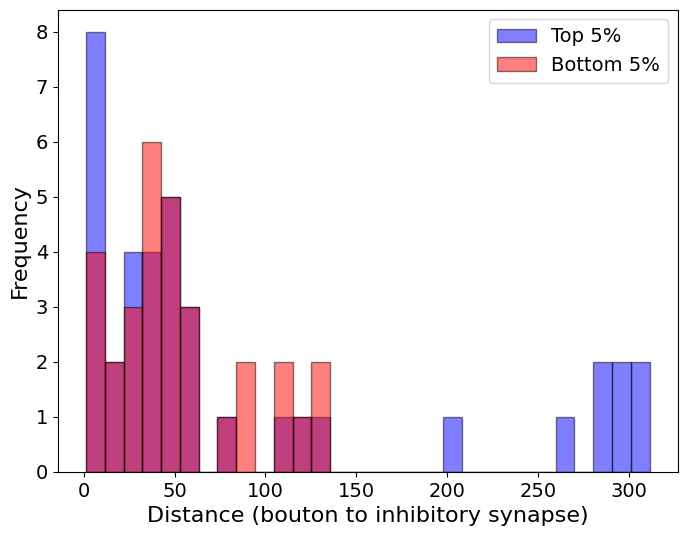

Min value: 0.595384395, Max value: 458.9018955, Total values: 345


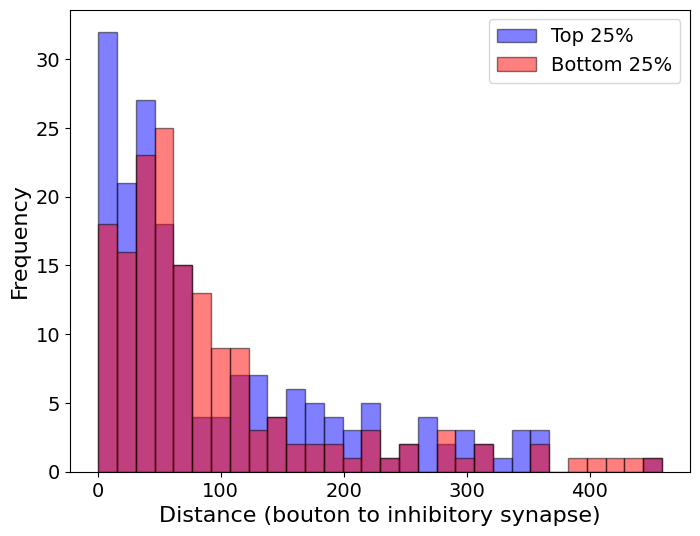

In [16]:
graph_bouton_inhib_dist(df_top_perc=df_top5perc_inhib, df_bottom_perc=df_bottom5perc_inhib, perc=5, save_filename='test_save.png')
graph_bouton_inhib_dist(df_top_perc=df_top25perc_inhib, df_bottom_perc=df_bottom25perc_inhib, perc=25, save_filename='test_save2.png')

In [17]:
df_proof_inh_1 = df_proofread[df_proofread['Cell_type'] == "Inhibitory"]
df_proof_inh_1.head(1)
print(len(df_proof_inh_1))

163
